# Taxi Fare Prediction with a Generalized Additive Model (GAM)

**Goal:** Predict NYC yellow taxi `fare_amount` from *non-fare* trip features — trip distance,
trip duration (derived), hour of day, day of week, and passenger count — using a Gaussian GAM
with identity link (`pygam.LinearGAM`).

The notebook loads raw trip-level Parquet data, engineers time-based features, fits a GAM
with smooth spline terms, evaluates on a held-out validation set, and interprets each
predictor's partial-dependence (term-effect) curve with 95 % confidence bands.

**Extra credit included (labeled [EC]):**
- Location PCA enrichment: HW2 PC1/PC2 scores joined on pickup zone as smooth GAM terms
- Bootstrap confidence-interval comparison: bootstrap-derived 95 % bands vs. pygam built-in CIs
- Per-term fare component breakdown chart

**EXTRA sections (beyond assignment scope — labeled [EXTRA]):**
- **EXTRA 1 — Seaborn EDA:** Richer exploratory visuals (fare distribution, fare vs hour violin, correlation heatmap) built with seaborn
- **EXTRA 2 — Region Analysis:** Assign all pickup/drop-off zones to NYC boroughs via lat/lon bounding boxes; compare fare distributions and fit per-borough GAMs to reveal spatial variation in the distance effect
- **EXTRA 3 — Multi-year & Multi-service:** Load samples from Yellow 2015, 2021, 2022 and Green 2021; compare fare distributions (seaborn violin) and overlay GAM distance partial-dependence curves to show how fares and rate structures changed over time and across services

In [15]:
# ── SciPy compatibility shim for pygam ('csr_matrix has no attribute A') ──
import scipy.sparse as _sp

for _cls in (_sp.csr_matrix, _sp.csc_matrix):
    if not hasattr(_cls, 'A'):
        _cls.A = property(lambda self: self.toarray())

# Make parent directory importable (for pivot_utils helpers)
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

try:
    from pygam import LinearGAM, s, l
    print('pygam imported successfully')
except ImportError:
    raise ImportError(
        'pygam not found. Install with: pip install pygam\n'
        'If scipy csr_matrix errors appear, the shim above should handle them.'
    )

print('All imports OK.')

pygam imported successfully
All imports OK.


In [16]:
# ═══════════════════════════  CONFIGURATION  ═══════════════════════════════

# Path to trip-level Parquet file (local path or S3 URI).
# Public TLC data accessed anonymously via s3fs.
DATA_PATH = 's3://dsc291-ucsd/taxi/Dataset/2021/yellow_taxi/yellow_tripdata_2021-01.parquet'

# Maximum rows to load after reading (None = use all rows in file).
MAX_ROWS = 100_000

# Reproducibility seed (used for sampling and train/val split).
RANDOM_SEED = 42

# Fraction of clean data to use for training; remainder goes to validation.
TRAIN_FRAC = 0.80

# Path to HW2 PC scores CSV (pickup_place → pc1, pc2, …)
PC_SCORES_PATH = '../hw2_output/pc_scores_by_pickup_place.csv'

# Number of bootstrap resamples for extra-credit CI comparison.
N_BOOTSTRAP = 50

# ── Extra-credit toggles ──────────────────────────────────────────────────
USE_LOCATION_PCA  = True   # Enrich features with HW2 PCA scores for pickup zone
DO_BOOTSTRAP      = True   # Compare bootstrap CIs vs. pygam built-in CIs
DO_FARE_BREAKDOWN = True   # Show per-term fare-component bar chart
# ═════════════════════════════════════════════════════════════════════════
print('Configuration loaded.')

Configuration loaded.


In [17]:
# ── Section 3: Load and Prepare Data ─────────────────────────────────────

def _find_col(columns, *patterns):
    """Return first column matching any regex pattern (case-insensitive)."""
    import re
    for pat in patterns:
        rx = re.compile(pat, re.IGNORECASE)
        for c in columns:
            if rx.fullmatch(str(c).strip()):
                return c
    return None


def load_trips(path, max_rows=None, seed=42):
    """Load trip-level parquet; handle local or S3 paths; sample if max_rows set."""
    storage_options = None
    if isinstance(path, str) and path.startswith('s3://'):
        storage_options = {'anon': True}
    df = pd.read_parquet(path, storage_options=storage_options)
    if max_rows is not None and len(df) > max_rows:
        df = df.sample(n=max_rows, random_state=seed)
    return df


def normalize_columns(df):
    """Detect and rename key columns to unified names; raise if required cols missing."""
    cols = list(df.columns)

    # ── datetime columns ──
    pickup_col  = _find_col(cols, r'tpep_pickup_datetime', r'pickup_datetime',
                             r'trip_pickup_datetime', r'.*pickup.*datetime.*')
    dropoff_col = _find_col(cols, r'tpep_dropoff_datetime', r'dropoff_datetime',
                             r'trip_dropoff_datetime', r'.*dropoff.*datetime.*')

    # ── numeric feature columns ──
    dist_col    = _find_col(cols, r'trip_distance', r'trip_dist', r'.*distance.*')
    pax_col     = _find_col(cols, r'passenger_count', r'passengers', r'pax_count')
    fare_col    = _find_col(cols, r'fare_amount', r'fare_amt', r'fare')
    loc_col     = _find_col(cols, r'pulocationid', r'pu_location_id', r'pickup_location',
                             r'pickup_place', r'pulocation')

    missing = [name for name, col in
               [('pickup_datetime', pickup_col), ('dropoff_datetime', dropoff_col),
                ('trip_distance',   dist_col),   ('fare_amount',      fare_col)]
               if col is None]
    if missing:
        raise ValueError(f'Could not find required columns: {missing}.\nAvailable: {cols}')

    rename = {pickup_col: 'pickup_datetime', dropoff_col: 'dropoff_datetime',
              dist_col: 'trip_distance', fare_col: 'fare_amount'}
    if pax_col:
        rename[pax_col] = 'passenger_count'
    if loc_col:
        rename[loc_col] = 'pickup_location'

    df = df.rename(columns=rename)

    # Keep only recognized columns
    keep = ['pickup_datetime', 'dropoff_datetime', 'trip_distance',
            'fare_amount'] + (
           ['passenger_count'] if 'passenger_count' in df.columns else []) + (
           ['pickup_location'] if 'pickup_location' in df.columns else [])
    return df[[c for c in keep if c in df.columns]]


print('Loading data from:', DATA_PATH)
raw_df = load_trips(DATA_PATH, max_rows=MAX_ROWS, seed=RANDOM_SEED)
print(f'  Loaded {len(raw_df):,} rows, {len(raw_df.columns)} columns.')
print('  Columns:', list(raw_df.columns))

df = normalize_columns(raw_df)
print(f'  After normalization: {list(df.columns)}')

Loading data from: s3://dsc291-ucsd/taxi/Dataset/2021/yellow_taxi/yellow_tripdata_2021-01.parquet
  Loaded 100,000 rows, 19 columns.
  Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
  After normalization: ['pickup_datetime', 'dropoff_datetime', 'trip_distance', 'fare_amount', 'passenger_count', 'pickup_location']


In [18]:
# ── Section 3 (cont.): Feature Engineering and Cleaning ──────────────────

# Parse datetimes
df['pickup_datetime']  = pd.to_datetime(df['pickup_datetime'],  errors='coerce')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')

# Derived temporal features
df['trip_duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60.0
df['hour_of_day']       = df['pickup_datetime'].dt.hour
df['day_of_week']       = df['pickup_datetime'].dt.dayofweek   # 0=Monday … 6=Sunday

# Fill missing passenger_count with 1
if 'passenger_count' not in df.columns:
    df['passenger_count'] = 1
df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce').fillna(1).clip(lower=1)

# ── Data Cleaning ──
before = len(df)
df = df.dropna(subset=['pickup_datetime', 'dropoff_datetime', 'trip_distance',
                        'fare_amount', 'trip_duration_min'])
df = df[
    (df['fare_amount']      > 0) &
    (df['trip_distance']    > 0) &
    (df['trip_duration_min'] > 0)
]

# Cap extreme values at 99th percentile
for col in ['fare_amount', 'trip_distance', 'trip_duration_min']:
    p99 = df[col].quantile(0.99)
    df = df[df[col] <= p99]

after = len(df)
print(f'Rows before cleaning: {before:,}  →  after cleaning: {after:,}  (removed {before - after:,})')

print('\nFeature summary:')
display(df[['fare_amount', 'trip_distance', 'trip_duration_min',
            'hour_of_day', 'day_of_week', 'passenger_count']].describe().round(3))

Rows before cleaning: 100,000  →  after cleaning: 94,789  (removed 5,211)

Feature summary:


,fare_amount,trip_distance,trip_duration_min,hour_of_day,day_of_week,passenger_count
count,94789.000,94789.000,94789.000,94789.000,94789.000,94789.000
mean,10.888,2.515,10.757,13.789,2.969,1.409
std,7.795,2.607,7.233,4.517,1.892,1.018
min,0.010,0.010,0.017,0.000,0.000,1.000
25%,6.000,1.000,5.567,11.000,1.000,1.000
50%,8.500,1.680,8.883,14.000,3.000,1.000
75%,12.500,2.870,13.967,17.000,5.000,1.000
max,52.000,17.910,44.217,23.000,6.000,6.000


In [19]:
# ── Section (Extra Credit): Location PCA Enrichment ───────────────────────
# Join HW2 PC1/PC2 scores by pickup zone so the GAM can absorb
# spatial structure via smooth terms on PC1 and PC2.

location_pca_joined = False

if USE_LOCATION_PCA and 'pickup_location' in df.columns:
    try:
        pc_scores = pd.read_csv(PC_SCORES_PATH)
        # Rename index col to pickup_location for the join
        first_col = pc_scores.columns[0]
        if first_col != 'pickup_location':
            pc_scores = pc_scores.rename(columns={first_col: 'pickup_location'})

        # Try to coerce both sides to the same type for join
        df['pickup_location'] = pd.to_numeric(df['pickup_location'], errors='coerce')
        pc_scores['pickup_location'] = pd.to_numeric(pc_scores['pickup_location'], errors='coerce')

        pc_sub = pc_scores[['pickup_location', 'pc1', 'pc2']].rename(
            columns={'pc1': 'pc1_score', 'pc2': 'pc2_score'})

        df = df.merge(pc_sub, on='pickup_location', how='left')

        matched = df['pc1_score'].notna().sum()
        print(f'PCA scores joined: {matched:,}/{len(df):,} rows matched a pickup zone.')

        if matched / len(df) >= 0.10:   # at least 10 % matched
            # Fill unmatched rows with median so no rows are dropped
            for col in ['pc1_score', 'pc2_score']:
                df[col] = df[col].fillna(df[col].median())
            location_pca_joined = True
            print('Location PCA enrichment ENABLED (pc1_score, pc2_score added to feature matrix).')
        else:
            df = df.drop(columns=['pc1_score', 'pc2_score'], errors='ignore')
            print('Match rate too low — skipping location PCA enrichment.')
    except Exception as e:
        print(f'Could not load PC scores ({e}) — skipping location PCA enrichment.')
else:
    if not USE_LOCATION_PCA:
        print('USE_LOCATION_PCA=False — skipping.')
    else:
        print('No pickup_location column found — skipping location PCA enrichment.')

PCA scores joined: 94,789/94,789 rows matched a pickup zone.
Location PCA enrichment ENABLED (pc1_score, pc2_score added to feature matrix).


In [20]:
# ── Section 3 (cont.): Train / Validation Split ───────────────────────────

# Build feature list in a fixed, documented order
FEATURE_NAMES = ['trip_distance', 'trip_duration_min', 'hour_of_day',
                 'day_of_week', 'passenger_count']
if location_pca_joined:
    FEATURE_NAMES += ['pc1_score', 'pc2_score']

TARGET = 'fare_amount'

X = df[FEATURE_NAMES].values
y = df[TARGET].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=TRAIN_FRAC, random_state=RANDOM_SEED
)

print(f'Feature matrix: {X.shape[1]} features → {FEATURE_NAMES}')
print(f'Train size: {len(X_train):,}   |   Validation size: {len(X_val):,}')

Feature matrix: 7 features → ['trip_distance', 'trip_duration_min', 'hour_of_day', 'day_of_week', 'passenger_count', 'pc1_score', 'pc2_score']
Train size: 75,831   |   Validation size: 18,958


In [21]:
# ── Section 4: Define and Fit the GAM ─────────────────────────────────────
# Smooth terms (s) for continuous/cyclic predictors; linear term (l) for
# passenger_count (discrete, small range).
#
# Feature index map:
#  0: trip_distance     → s(0)  cyclic=False
#  1: trip_duration_min → s(1)  cyclic=False
#  2: hour_of_day       → s(2)  cyclic=True  (0..23 wraps)
#  3: day_of_week       → s(3)  cyclic=True  (0..6 wraps)
#  4: passenger_count   → l(4)  linear
#  5: pc1_score         → s(5)  [if location_pca_joined]
#  6: pc2_score         → s(6)  [if location_pca_joined]

terms = s(0) + s(1) + s(2, n_splines=24, spline_order=3) + s(3, n_splines=7) + l(4)
if location_pca_joined:
    terms = terms + s(5) + s(6)

gam = LinearGAM(terms, fit_intercept=True)

# Simple lambda grid search over log-space values
gam.gridsearch(X_train, y_train, progress=False)

print('GAM fit complete.')
print(gam.summary())

GAM fit complete.
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    101.3866
Link Function:                     IdentityLink Log Likelihood:                               -194085.7799
Number of Samples:                        75831 AIC:                                           388376.3329
                                                AICc:                                          388376.6125
                                                GCV:                                                4.6417
                                                Scale:                                              4.6306
                                                Pseudo R-Squared:                                   0.9236
Feature Function   

Validation set metrics:


'  Metric  Value\nRMSE ($) 2.1603\n MAE ($) 0.7490\n      R² 0.9244'

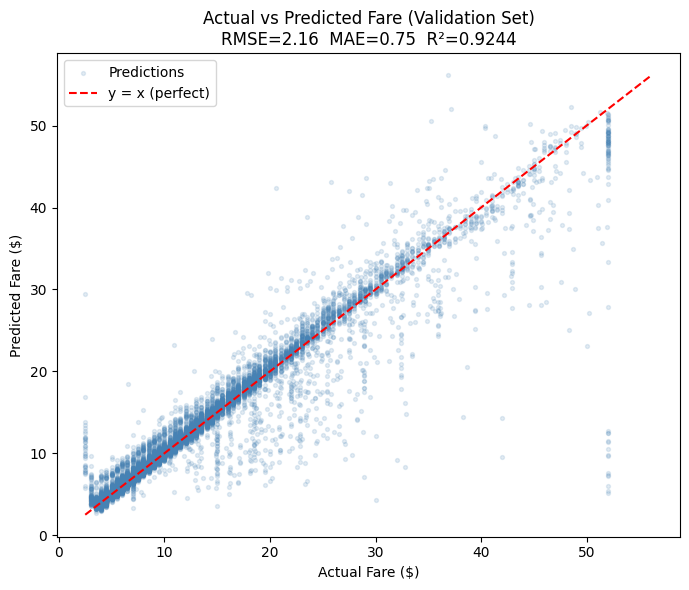

Scatter plot saved to hw3_output/actual_vs_predicted.png


In [22]:
# ── Section 5: Evaluate ────────────────────────────────────────────────────

y_pred = gam.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae  = mean_absolute_error(y_val, y_pred)
r2   = r2_score(y_val, y_pred)

metrics_df = pd.DataFrame({'Metric': ['RMSE ($)', 'MAE ($)', 'R²'],
                            'Value':  [f'{rmse:.4f}', f'{mae:.4f}', f'{r2:.4f}']})
print('Validation set metrics:')
display(metrics_df.to_string(index=False))

# ── Actual vs. Predicted scatter plot ─────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_val, y_pred, alpha=0.15, s=8, color='steelblue', label='Predictions')
lims = [min(y_val.min(), y_pred.min()), max(y_val.max(), y_pred.max())]
ax.plot(lims, lims, 'r--', linewidth=1.5, label='y = x (perfect)')
ax.set_xlabel('Actual Fare ($)')
ax.set_ylabel('Predicted Fare ($)')
ax.set_title(f'Actual vs Predicted Fare (Validation Set)\nRMSE={rmse:.2f}  MAE={mae:.2f}  R²={r2:.4f}')
ax.legend()
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=120)
plt.show()
print('Scatter plot saved to hw3_output/actual_vs_predicted.png')

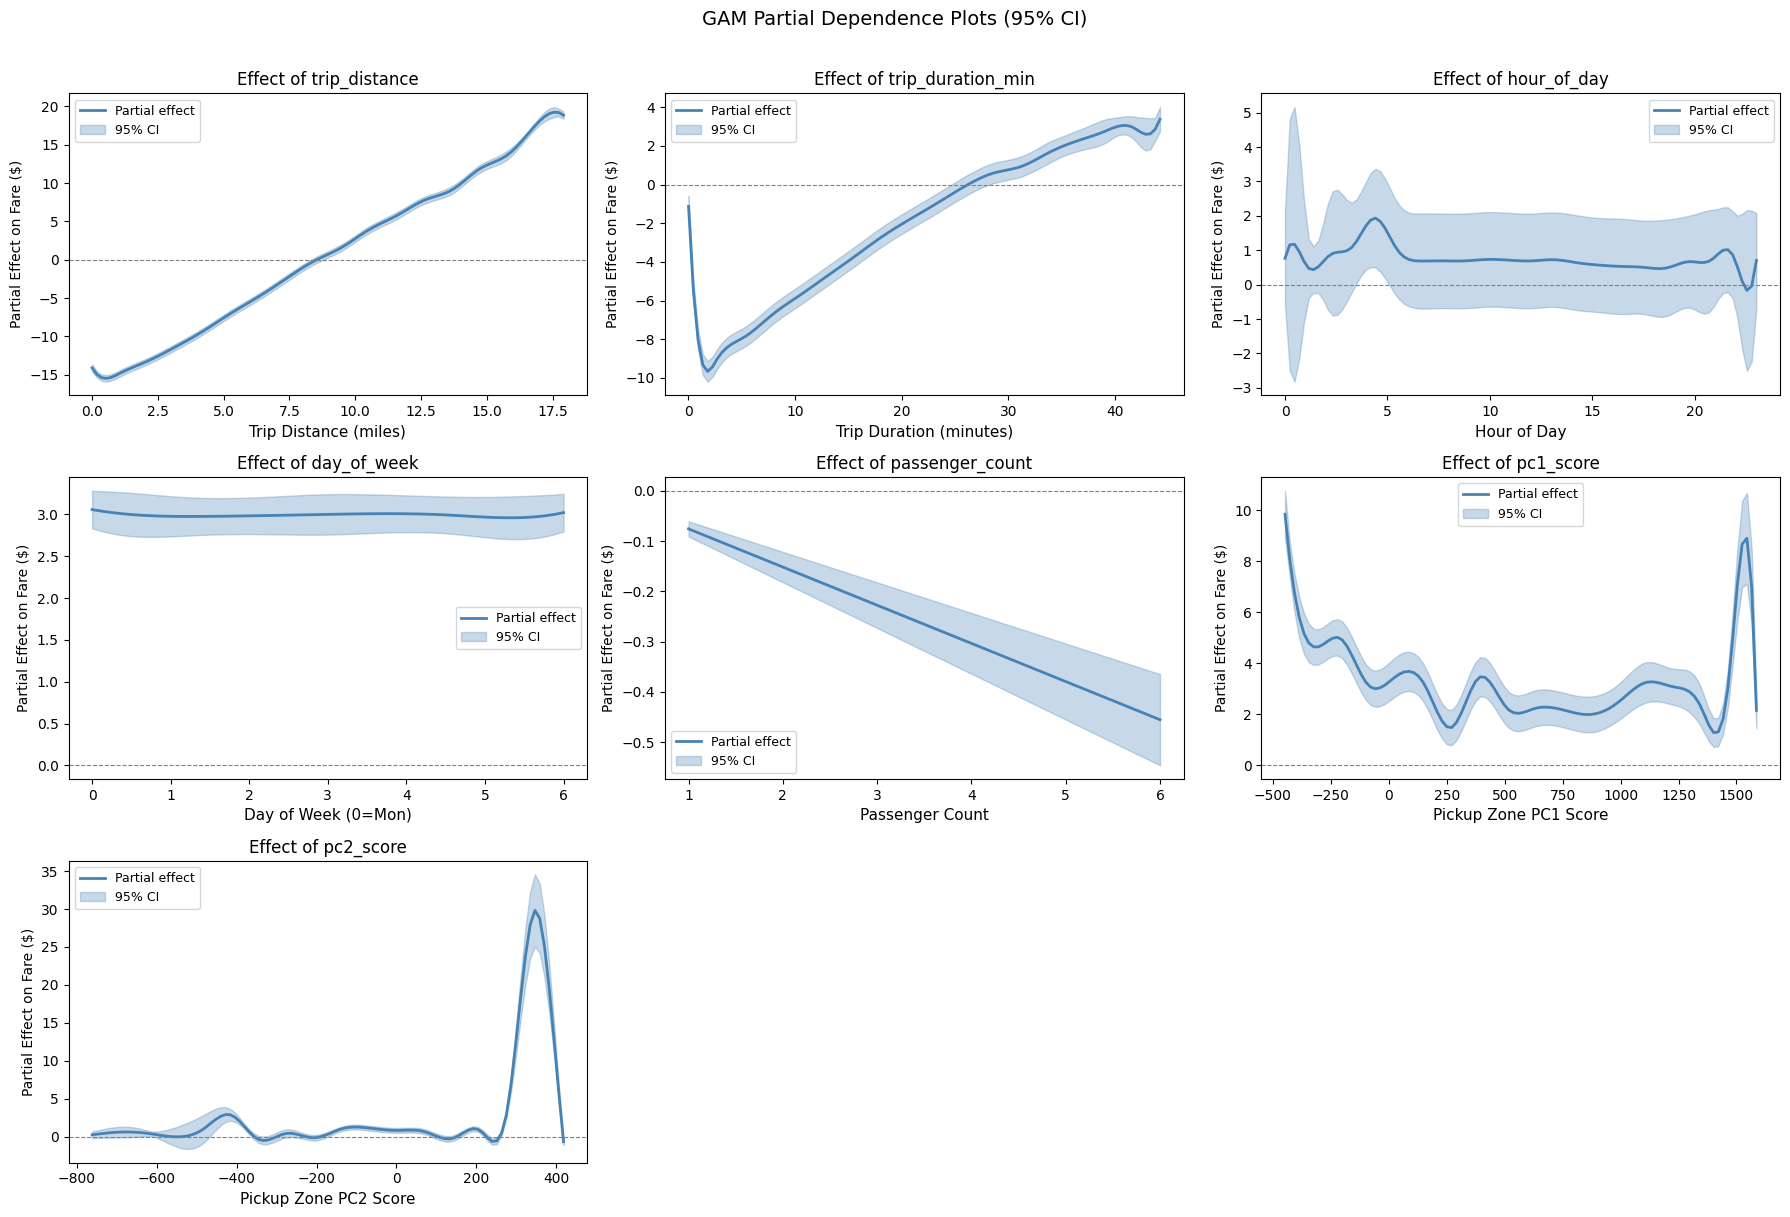

Partial dependence plots saved to hw3_output/partial_dependence.png


In [23]:
# ── Section 6: Partial Dependence (Term Effect) Plots ─────────────────────
# Plots how each predictor relates to fare while holding others at a reference
# value.  95 % confidence intervals shown as shaded bands.

TERM_LABELS = {
    0: ('trip_distance',     'Trip Distance (miles)'),
    1: ('trip_duration_min', 'Trip Duration (minutes)'),
    2: ('hour_of_day',       'Hour of Day'),
    3: ('day_of_week',       'Day of Week (0=Mon)'),
    4: ('passenger_count',   'Passenger Count'),
}
if location_pca_joined:
    TERM_LABELS[5] = ('pc1_score', 'Pickup Zone PC1 Score')
    TERM_LABELS[6] = ('pc2_score', 'Pickup Zone PC2 Score')

n_terms = len(TERM_LABELS)
ncols = 3
nrows = (n_terms + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
axes = np.array(axes).flatten()

for idx, (term_i, (feat_name, xlabel)) in enumerate(TERM_LABELS.items()):
    ax = axes[idx]
    XX = gam.generate_X_grid(term=term_i)
    pdep, confi = gam.partial_dependence(term=term_i, X=XX, width=0.95)
    ax.plot(XX[:, term_i], pdep, color='steelblue', linewidth=2, label='Partial effect')
    ax.fill_between(XX[:, term_i], confi[:, 0], confi[:, 1],
                    alpha=0.3, color='steelblue', label='95% CI')
    ax.axhline(0, color='grey', linewidth=0.8, linestyle='--')
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel('Partial Effect on Fare ($)', fontsize=10)
    ax.set_title(f'Effect of {feat_name}', fontsize=12)
    ax.legend(fontsize=9)

# Hide any unused subplot panels
for j in range(n_terms, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('GAM Partial Dependence Plots (95% CI)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('partial_dependence.png', dpi=120, bbox_inches='tight')
plt.show()
print('Partial dependence plots saved to hw3_output/partial_dependence.png')

Running 50 bootstrap fits (this may take ~1-2 min)…
  10/50 done
  20/50 done
  30/50 done
  40/50 done
  50/50 done
Bootstrap complete.  Plotting CI comparison…


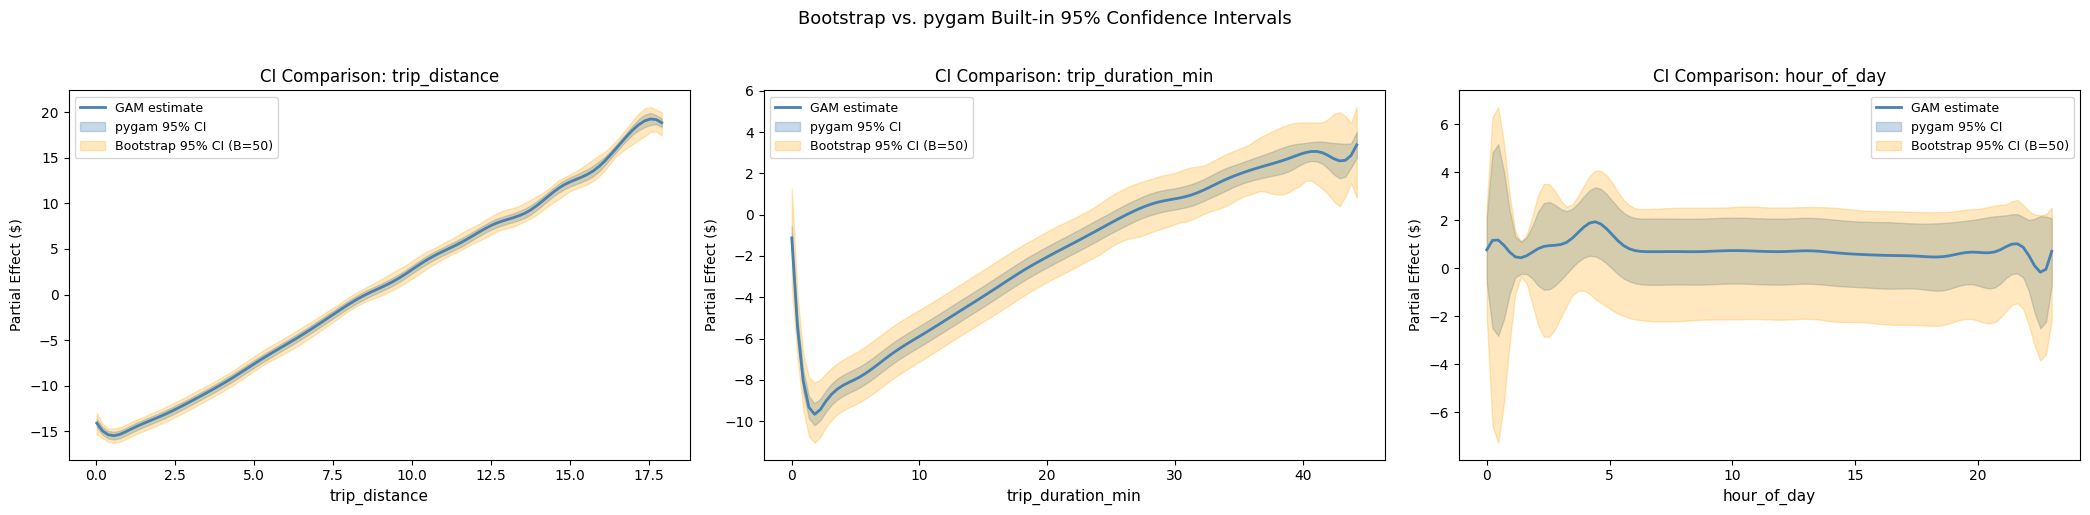

Bootstrap CI comparison saved to hw3_output/bootstrap_ci_comparison.png


In [24]:
# ── Extra Credit: Bootstrap CI Comparison ─────────────────────────────────
# For 3 key terms (trip_distance, trip_duration_min, hour_of_day), we compare:
#   (a) pygam's built-in 95 % CI (computed from the GAM covariance matrix)
#   (b) Bootstrap 95 % CI (percentile method, N_BOOTSTRAP resamples)
# This lets us assess whether pygam's analytical CIs are realistic.

if not DO_BOOTSTRAP:
    print('DO_BOOTSTRAP=False — skipping.')
else:
    BOOT_TERMS = [0, 1, 2]   # indices: trip_distance, trip_duration_min, hour_of_day
    BOOT_LABELS = ['trip_distance', 'trip_duration_min', 'hour_of_day']

    # Pre-compute evaluation grids from the full GAM
    boot_grids   = [gam.generate_X_grid(term=t) for t in BOOT_TERMS]
    # Storage: list of arrays shape (N_BOOTSTRAP, n_grid_points)
    boot_curves  = [[] for _ in BOOT_TERMS]

    rng = np.random.default_rng(RANDOM_SEED)
    n_train = len(X_train)

    print(f'Running {N_BOOTSTRAP} bootstrap fits (this may take ~1-2 min)…')
    for b in range(N_BOOTSTRAP):
        idx = rng.integers(0, n_train, size=n_train)   # resample with replacement
        Xb, yb = X_train[idx], y_train[idx]
        try:
            gam_b = LinearGAM(terms, fit_intercept=True)
            # Fix lambdas to those found by gridsearch (faster, more stable)
            gam_b.lam = gam.lam
            gam_b.fit(Xb, yb)
            for k, (term_i, grid) in enumerate(zip(BOOT_TERMS, boot_grids)):
                pdep_b, _ = gam_b.partial_dependence(term=term_i, X=grid, width=0.95)
                boot_curves[k].append(pdep_b)
        except Exception:
            pass
        if (b + 1) % 10 == 0:
            print(f'  {b + 1}/{N_BOOTSTRAP} done')

    print('Bootstrap complete.  Plotting CI comparison…')

    fig, axes = plt.subplots(1, len(BOOT_TERMS), figsize=(7 * len(BOOT_TERMS), 5))
    if len(BOOT_TERMS) == 1:
        axes = [axes]

    for k, (term_i, feat_label) in enumerate(zip(BOOT_TERMS, BOOT_LABELS)):
        ax = axes[k]
        grid = boot_grids[k]
        x_vals = grid[:, term_i]

        # pygam analytic CI
        pdep_main, confi_main = gam.partial_dependence(term=term_i, X=grid, width=0.95)

        # Bootstrap percentile CI
        curves_arr = np.array(boot_curves[k])  # shape (n_valid, n_grid)
        boot_lo = np.percentile(curves_arr, 2.5,  axis=0)
        boot_hi = np.percentile(curves_arr, 97.5, axis=0)

        ax.plot(x_vals, pdep_main, color='steelblue', linewidth=2, label='GAM estimate')
        ax.fill_between(x_vals, confi_main[:, 0], confi_main[:, 1],
                        alpha=0.30, color='steelblue', label='pygam 95% CI')
        ax.fill_between(x_vals, boot_lo, boot_hi,
                        alpha=0.25, color='orange', label=f'Bootstrap 95% CI (B={len(curves_arr)})')
        ax.set_xlabel(feat_label, fontsize=11)
        ax.set_ylabel('Partial Effect ($)')
        ax.set_title(f'CI Comparison: {feat_label}', fontsize=12)
        ax.legend(fontsize=9)

    plt.suptitle('Bootstrap vs. pygam Built-in 95% Confidence Intervals', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.savefig('bootstrap_ci_comparison.png', dpi=120, bbox_inches='tight')
    plt.show()
    print('Bootstrap CI comparison saved to hw3_output/bootstrap_ci_comparison.png')

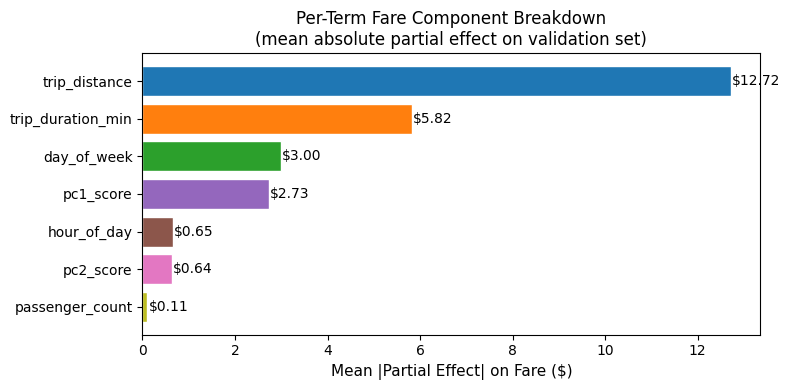


Fare Component Breakdown (mean |partial effect| on validation set):
  trip_distance            : $12.715
  trip_duration_min        : $5.815
  day_of_week              : $3.001
  pc1_score                : $2.732
  hour_of_day              : $0.651
  pc2_score                : $0.641
  passenger_count          : $0.108
  intercept                : $21.964
Component chart saved to hw3_output/fare_component_breakdown.png


In [25]:
# ── Extra Credit: Per-Term Fare Component Breakdown ────────────────────────
# Quantify how much each predictor contributes to the average predicted fare.
# For each term i, we evaluate its partial_dependence at the training-set mean
# of X and report the absolute contribution (additive effect).

if not DO_FARE_BREAKDOWN:
    print('DO_FARE_BREAKDOWN=False — skipping.')
else:
    # Use the validation set to measure average partial contributions
    contributions = {}
    for term_i, (feat_name, xlabel) in TERM_LABELS.items():
        pdep, _ = gam.partial_dependence(term=term_i, X=X_val, width=0.95)
        contributions[feat_name] = float(np.mean(np.abs(pdep)))

    # Also include the fitted intercept as a separate component
    intercept_val = float(gam.coef_[-1])   # last coefficient is intercept

    labels = list(contributions.keys())
    values = list(contributions.values())

    # Sort descending
    sorted_pairs = sorted(zip(values, labels), reverse=True)
    values_sorted, labels_sorted = zip(*sorted_pairs)

    colors = plt.cm.tab10(np.linspace(0, 0.8, len(labels_sorted)))

    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.barh(labels_sorted, values_sorted, color=colors, edgecolor='white')
    ax.set_xlabel('Mean |Partial Effect| on Fare ($)', fontsize=11)
    ax.set_title('Per-Term Fare Component Breakdown\n(mean absolute partial effect on validation set)', fontsize=12)
    for bar, v in zip(bars, values_sorted):
        ax.text(v + 0.02, bar.get_y() + bar.get_height() / 2,
                f'${v:.2f}', va='center', fontsize=10)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig('fare_component_breakdown.png', dpi=120, bbox_inches='tight')
    plt.show()

    print('\nFare Component Breakdown (mean |partial effect| on validation set):')
    for feat, val in sorted(contributions.items(), key=lambda x: -x[1]):
        print(f'  {feat:25s}: ${val:.3f}')
    print(f'  {"intercept":25s}: ${intercept_val:.3f}')
    print('Component chart saved to hw3_output/fare_component_breakdown.png')

## Discussion: Limitations

The GAM provides a transparent and interpretable model for taxi fare prediction, but several
limitations constrain its real-world accuracy:

1. **Missing fare components**: The model intentionally excludes tolls, MTA taxes, congestion
   surcharges, and airport fees — all of which add fixed or route-dependent charges to the
   actual meter reading.  A trip through a toll zone will therefore be systematically
   under-predicted.

2. **No fine-grained GPS location**: Pickup/drop-off coordinates or street segments are not
   used directly; instead, location is represented only through aggregate PCA scores derived
   from the ride-count wide table.  Route geometry (e.g. highway vs. local streets) and
   traffic conditions are therefore not captured.

3. **Single-month snapshot**: The model is trained on January 2021 data only.  Seasonal demand
   patterns, holiday effects, and post-pandemic ridership recovery trends visible in later
   months are absent.

4. **Passenger-count noise**: Many NYC TLC records have `passenger_count = 0` or suspiciously
   high values; even after cleaning, this feature has low predictive power for fare.

---

# EXTRA: Extended Analyses

The three sections below go beyond the core assignment requirements.
All figures are labeled **[EXTRA]** and all code blocks begin with the comment `# EXTRA`.

| Section | What it adds |
|---------|-------------|
| **EXTRA 1 — Seaborn EDA** | Richer exploratory visuals using seaborn: fare distribution, fare vs hour violin, feature correlation heatmap |
| **EXTRA 2 — Region Analysis** | Divide pickup/drop-off zones into NYC boroughs using `taxi_zone_lookup.csv`; compare fare distributions and GAM fits per region |
| **EXTRA 3 — Multi-year & Multi-service Comparison** | Load samples from 2015, 2021, 2022 yellow taxi + 2021 green taxi; compare fare distributions and partial-dependence curves across years and services |

## EXTRA 1 — Seaborn EDA

Exploratory visualizations of the cleaned trip data using seaborn — fare distribution,
fare vs hour-of-day, and a feature correlation heatmap.

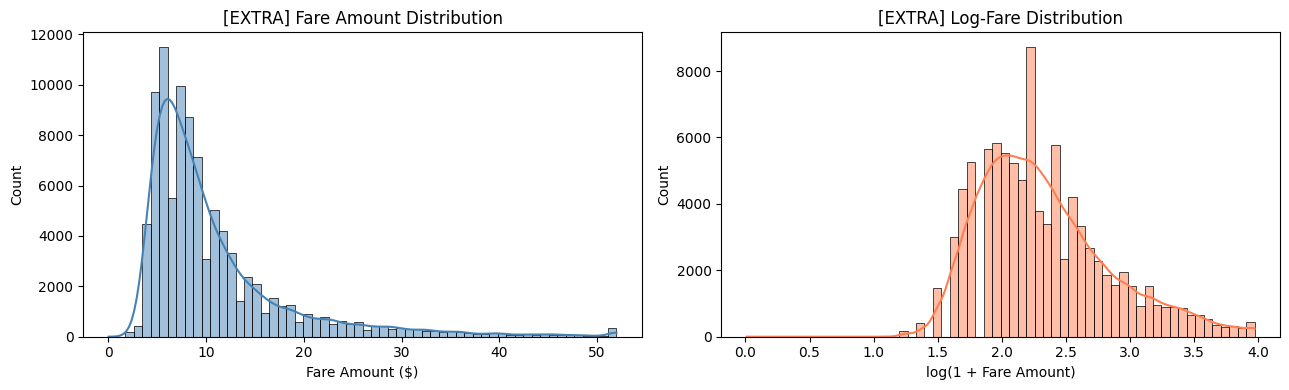

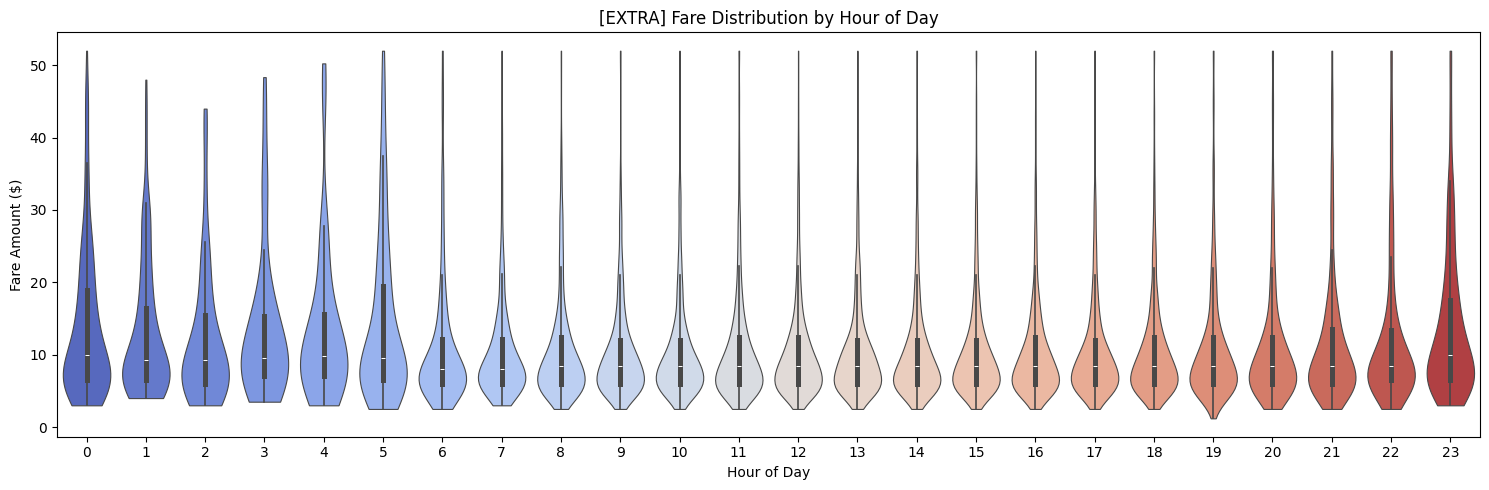

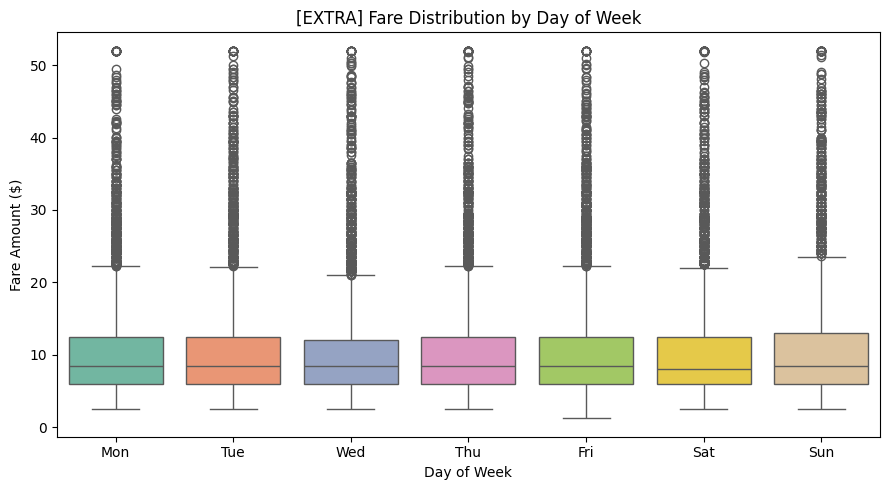

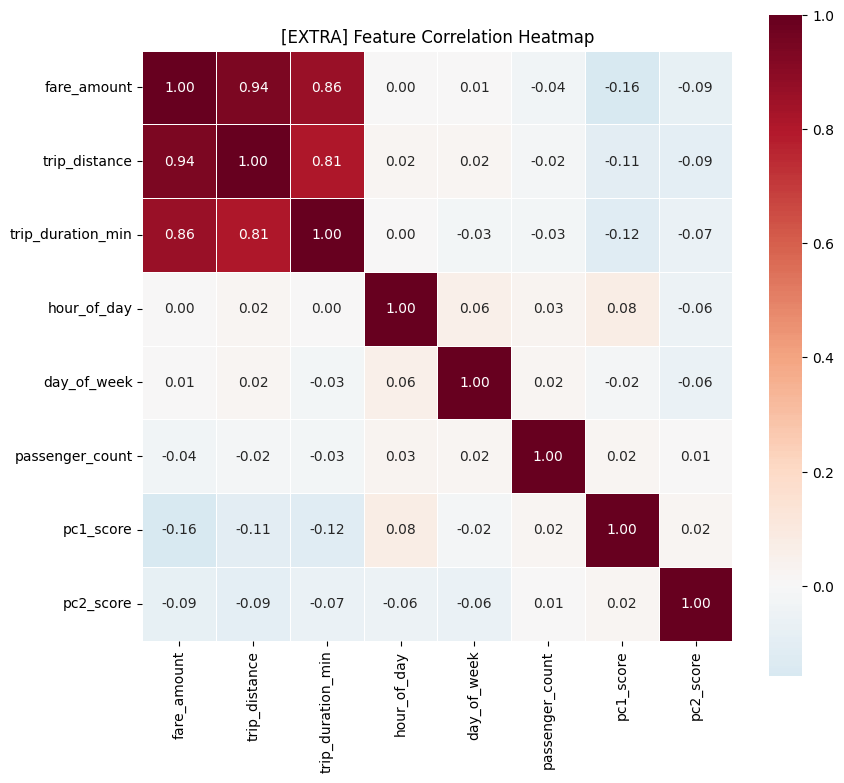

EXTRA 1 figures saved.


In [28]:
# EXTRA 1 — Seaborn EDA
# Uses the cleaned `df` produced by Sections 3–4 above.
# Requires seaborn (imported in cell 2).

import seaborn as sns

extra_df = df.copy()

# ── 1a. Fare amount distribution ─────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sns.histplot(extra_df['fare_amount'], bins=60, kde=True,
             color='steelblue', ax=axes[0])
axes[0].set_xlabel('Fare Amount ($)')
axes[0].set_title('[EXTRA] Fare Amount Distribution')

sns.histplot(np.log1p(extra_df['fare_amount']), bins=60, kde=True,
             color='coral', ax=axes[1])
axes[1].set_xlabel('log(1 + Fare Amount)')
axes[1].set_title('[EXTRA] Log-Fare Distribution')

plt.tight_layout()
plt.savefig('extra_fare_distribution.png', dpi=120, bbox_inches='tight')
plt.show()

# ── 1b. Fare vs hour of day (violin) ──────────────────────────────────────
# Sample to keep rendering fast
violin_sample = extra_df.sample(min(30_000, len(extra_df)), random_state=RANDOM_SEED)

fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(data=violin_sample, x='hour_of_day', y='fare_amount',
               palette='coolwarm', cut=0, linewidth=0.8, ax=ax)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Fare Amount ($)')
ax.set_title('[EXTRA] Fare Distribution by Hour of Day')
plt.tight_layout()
plt.savefig('extra_fare_by_hour_violin.png', dpi=120, bbox_inches='tight')
plt.show()

# ── 1c. Fare vs day of week (box) ─────────────────────────────────────────
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
violin_sample['day_label'] = violin_sample['day_of_week'].map(dict(enumerate(day_labels)))

fig, ax = plt.subplots(figsize=(9, 5))
sns.boxplot(data=violin_sample, x='day_label', y='fare_amount',
            order=day_labels, palette='Set2', ax=ax)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Fare Amount ($)')
ax.set_title('[EXTRA] Fare Distribution by Day of Week')
plt.tight_layout()
plt.savefig('extra_fare_by_dow.png', dpi=120, bbox_inches='tight')
plt.show()

# ── 1d. Feature correlation heatmap ──────────────────────────────────────
corr_cols = ['fare_amount', 'trip_distance', 'trip_duration_min',
             'hour_of_day', 'day_of_week', 'passenger_count']
if location_pca_joined:
    corr_cols += ['pc1_score', 'pc2_score']

corr = extra_df[corr_cols].corr()
fig, ax = plt.subplots(figsize=(len(corr_cols) + 1, len(corr_cols)))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('[EXTRA] Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('extra_correlation_heatmap.png', dpi=120, bbox_inches='tight')
plt.show()

print('EXTRA 1 figures saved.')

## EXTRA 2 — Region Analysis (Pickup/Drop-off by NYC Borough)

NYC has 263 taxi zones spread across 5 boroughs. Analysing zone IDs alone makes interpretation
difficult; grouping them into boroughs reveals spatial fare patterns that individual zone IDs obscure.

**Method:** The HW2 taxi zone lookup (`taxi_zone_lookup.csv`) provides the official borough for each
zone ID. We join the borough label onto the trip data on `pickup_location`, then compare fare
distributions across boroughs and fit a separate GAM per borough to see how distance/duration
effects differ spatially.

Borough distribution across zones:
borough
Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
Unknown           2
EWR               1

Trips matched to a borough: 99.3%
borough
Manhattan        87723
Queens            3874
Brooklyn          1659
Bronx              851
Unknown            677
Staten Island        5


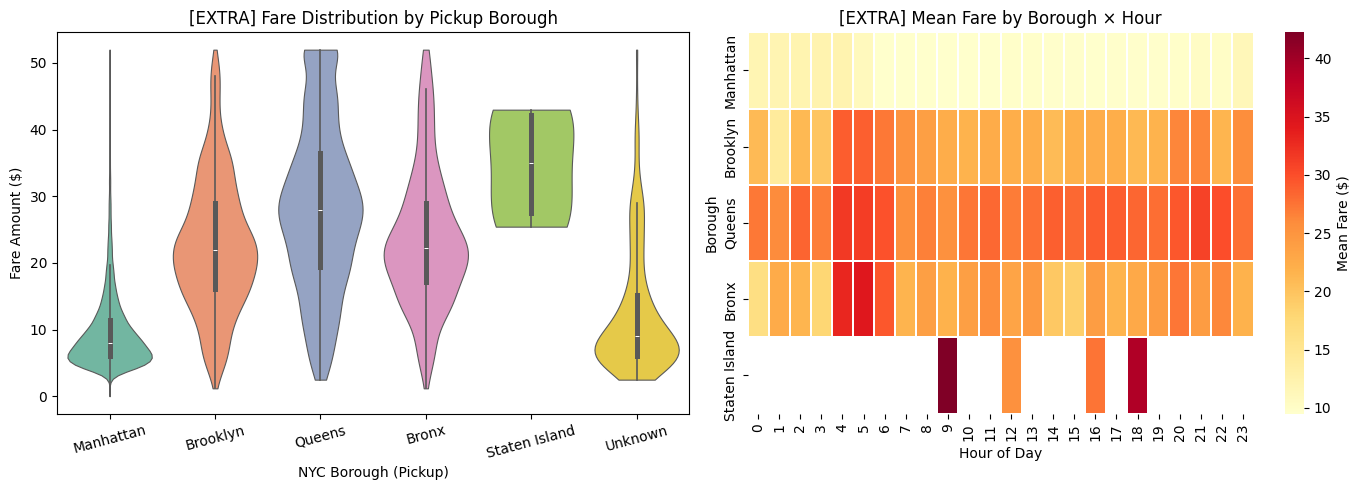

  Skipping Staten Island — only 5 rows.


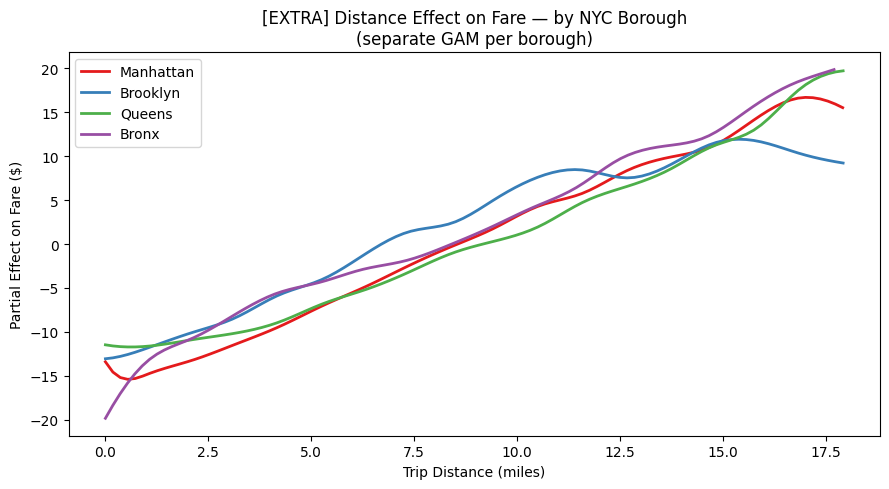

EXTRA 2 figures saved.


In [31]:
# EXTRA 2 — Region / Borough Assignment and Analysis

ZONES_CSV_PATH = '../hw2_output/taxi_zone_lookup.csv'   # LocationID, Borough, Zone, service_zone

# ── 2a. Load zone lookup (LocationID → Borough) and join onto trip data ─────
region_df = None
try:
    zones = pd.read_csv(ZONES_CSV_PATH)
    zones.columns = [c.strip().lower() for c in zones.columns]
    zones = zones.rename(columns={'locationid': 'pickup_location'})
    zones = zones[['pickup_location', 'borough']].drop_duplicates()

    print('Borough distribution across zones:')
    print(zones['borough'].value_counts().to_string())

    if 'pickup_location' in df.columns:
        region_df = df.copy()
        region_df['pickup_location'] = pd.to_numeric(region_df['pickup_location'], errors='coerce')
        region_df = region_df.merge(zones, on='pickup_location', how='left')
        region_df['borough'] = region_df['borough'].fillna('Unknown')
        match_pct = (region_df['borough'] != 'Unknown').mean() * 100
        print(f'\nTrips matched to a borough: {match_pct:.1f}%')
        print(region_df['borough'].value_counts().to_string())
    else:
        print('pickup_location column not available — skipping join.')
except Exception as e:
    print(f'Could not load zones CSV ({e}) — EXTRA 2 region analysis skipped.')

# ── 2b. Fare distribution by borough (violin + box) ───────────────────────
if region_df is not None and 'borough' in region_df.columns:
    BOROUGH_ORDER = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'Unknown']
    present_boroughs = [b for b in BOROUGH_ORDER if b in region_df['borough'].values]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.violinplot(data=region_df, x='borough', y='fare_amount',
                   order=present_boroughs, palette='Set2', cut=0, linewidth=0.8,
                   ax=axes[0])
    axes[0].set_xlabel('NYC Borough (Pickup)')
    axes[0].set_ylabel('Fare Amount ($)')
    axes[0].set_title('[EXTRA] Fare Distribution by Pickup Borough')
    axes[0].tick_params(axis='x', rotation=15)

    # avg fare per borough × hour heatmap
    pivot = (region_df[region_df['borough'].isin(present_boroughs) & (region_df['borough'] != 'Unknown')]
             .groupby(['borough', 'hour_of_day'])['fare_amount']
             .mean()
             .unstack(fill_value=np.nan))
    sns.heatmap(pivot.reindex([b for b in present_boroughs if b != 'Unknown']),
                cmap='YlOrRd', linewidths=0.3, annot=False, ax=axes[1],
                cbar_kws={'label': 'Mean Fare ($)'})
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Borough')
    axes[1].set_title('[EXTRA] Mean Fare by Borough × Hour')

    plt.tight_layout()
    plt.savefig('extra_fare_by_region.png', dpi=120, bbox_inches='tight')
    plt.show()

    # ── 2c. GAM partial dependence for trip_distance, stratified by borough ──
    from pygam import LinearGAM, s, l

    borough_gams = {}
    BOROUGH_COLORS = {
        'Manhattan': '#e41a1c', 'Brooklyn': '#377eb8', 'Queens': '#4daf4a',
        'Bronx': '#984ea3', 'Staten Island': '#ff7f00',
    }

    fig, ax = plt.subplots(figsize=(9, 5))
    for bor in [b for b in present_boroughs if b != 'Unknown']:
        sub = region_df[region_df['borough'] == bor].dropna(
            subset=['trip_distance', 'trip_duration_min', 'fare_amount'])
        if len(sub) < 200:
            print(f'  Skipping {bor} — only {len(sub)} rows.')
            continue

        Xb = sub[['trip_distance', 'trip_duration_min', 'hour_of_day',
                   'day_of_week', 'passenger_count']].values
        yb = sub['fare_amount'].values
        gam_b = LinearGAM(s(0) + s(1) + s(2, n_splines=24) + s(3, n_splines=7) + l(4),
                          fit_intercept=True)
        try:
            gam_b.fit(Xb, yb)
        except Exception:
            continue

        XX_b = gam_b.generate_X_grid(term=0)
        pdep_b, _ = gam_b.partial_dependence(term=0, X=XX_b, width=0.95)
        ax.plot(XX_b[:, 0], pdep_b, linewidth=2, label=bor,
                color=BOROUGH_COLORS.get(bor, None))
        borough_gams[bor] = gam_b

    ax.set_xlabel('Trip Distance (miles)')
    ax.set_ylabel('Partial Effect on Fare ($)')
    ax.set_title('[EXTRA] Distance Effect on Fare — by NYC Borough\n(separate GAM per borough)')
    ax.legend()
    plt.tight_layout()
    plt.savefig('extra_gam_by_region.png', dpi=120, bbox_inches='tight')
    plt.show()
    print('EXTRA 2 figures saved.')
else:
    print('EXTRA 2 skipped (no region data).')

## EXTRA 3 — Multi-year & Multi-service Fare Comparison (2015 · 2021 · 2022 · Green)

NYC taxi fares changed markedly between 2015, 2021, and 2022:
- **2015** — pre-app era; fares set by TLC meter.
- **2021** — COVID recovery; lower ridership, same meter rates.
- **2022** — post-COVID rebound; MTA congestion surcharge introduced in late 2021.

We also include **green taxi** (2021) to compare fare structures between medallion yellow cabs
(Manhattan-focused) and outer-borough green cabs.

**Method:** Load a small sample (≤ 30k rows) from each source, normalize schemas, pool with a
`service` label, and compare:
1. Fare distributions (seaborn violin)
2. Distance-vs-fare scatter (seaborn `lmplot`)
3. GAM partial-dependence curves for `trip_distance` overlaid for all services/years

Loading multi-year / multi-service samples...
  Yellow 2015    : 29,105 rows loaded from s3://dsc291-ucsd/taxi/Dataset/2015/yellow_taxi/yellow_tripdata_2015-01.parquet
  Yellow 2021    : 28,474 rows loaded from s3://dsc291-ucsd/taxi/Dataset/2021/yellow_taxi/yellow_tripdata_2021-01.parquet
  Yellow 2022    : 28,611 rows loaded from s3://dsc291-ucsd/taxi/Dataset/2022/yellow_taxi/yellow_tripdata_2022-01.parquet
  Green 2021     : 28,127 rows loaded from s3://dsc291-ucsd/taxi/Dataset/2021/green_taxi/green_tripdata_2021-01.parquet

Combined: 114,317 rows across 4 services.


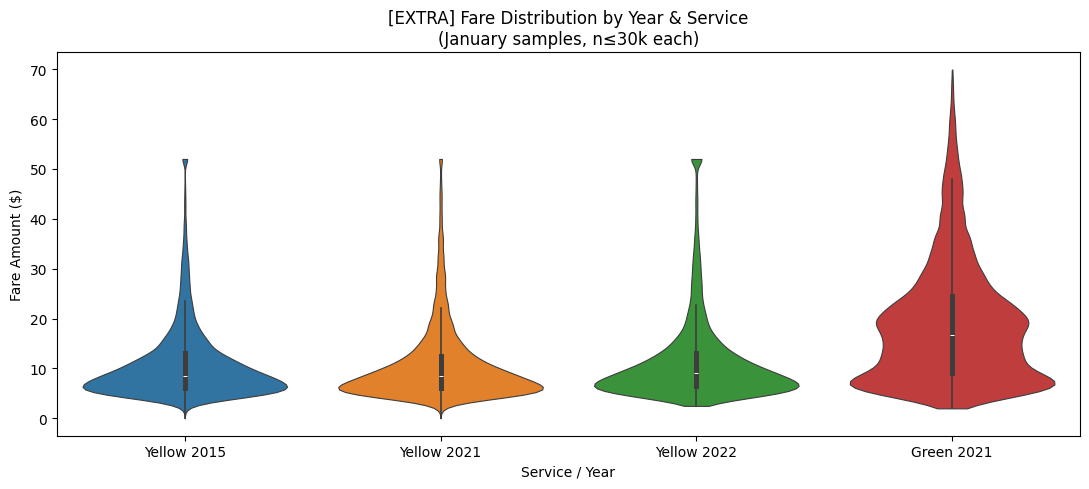


Fare statistics by service:


,n,mean,median,std,p25,p75
service,,,,,,
Green 2021,28127,18.90,16.73,12.21,9.0,24.62
Yellow 2015,29105,10.93,8.50,7.40,6.0,13.00
Yellow 2021,28474,10.86,8.50,7.73,6.0,12.50
Yellow 2022,28611,11.57,9.00,8.67,6.5,13.00


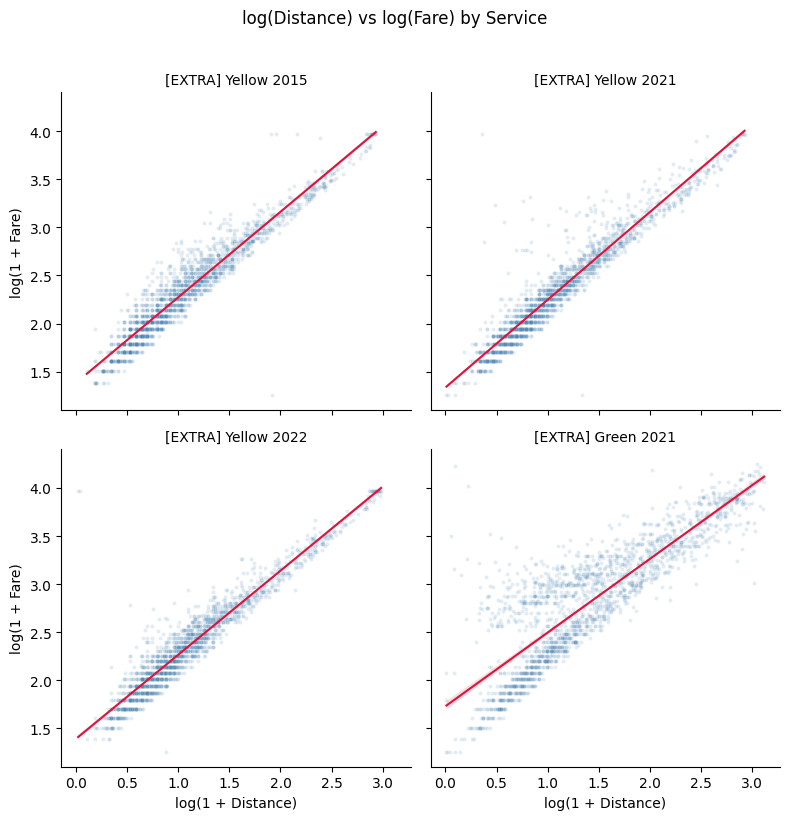


Fitting one GAM per service for partial-dependence comparison...


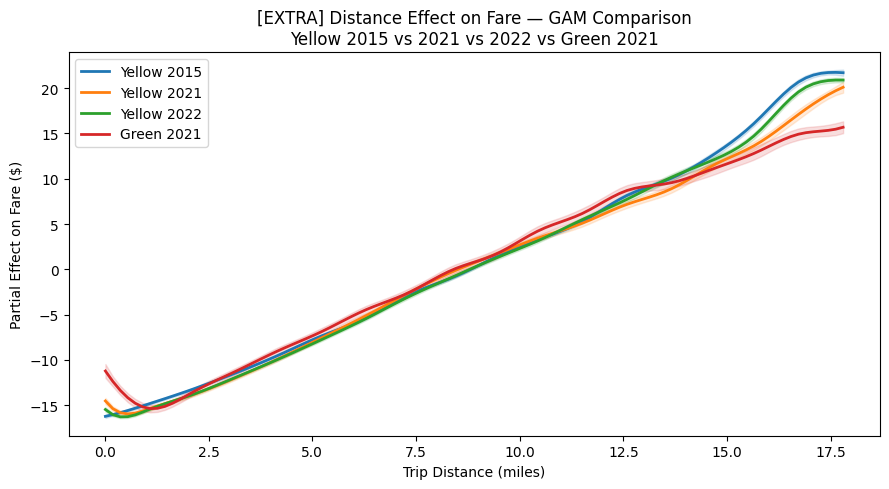

EXTRA 3 figures saved.


In [30]:
# EXTRA 3 — Multi-year & Multi-service Fare Comparison

# ── Dataset catalog ────────────────────────────────────────────────────────
# Each entry: (label, S3 path, month to load)
# All paths use the same anonymous S3 bucket pattern as the main data.
# Paths that don't exist will be skipped gracefully.
S3_BASE = 's3://dsc291-ucsd/taxi/Dataset'
MULTI_SOURCES = [
    ('Yellow 2015', f'{S3_BASE}/2015/yellow_taxi/yellow_tripdata_2015-01.parquet'),
    ('Yellow 2021', f'{S3_BASE}/2021/yellow_taxi/yellow_tripdata_2021-01.parquet'),  # same as main
    ('Yellow 2022', f'{S3_BASE}/2022/yellow_taxi/yellow_tripdata_2022-01.parquet'),
    ('Green 2021',  f'{S3_BASE}/2021/green_taxi/green_tripdata_2021-01.parquet'),
]
MULTI_MAX_ROWS = 30_000   # per source — keep it fast

# ── Helper functions (reuse normalize_columns from Section 3) ──────────────
def load_and_normalize(label, path, max_rows=MULTI_MAX_ROWS, seed=RANDOM_SEED):
    """
    Load a parquet from local or S3, normalize columns, derive features.
    Returns a small cleaned DataFrame with a 'service' column, or None on failure.
    """
    try:
        storage_options = {'anon': True} if path.startswith('s3://') else None
        tmp = pd.read_parquet(path, storage_options=storage_options)
        if len(tmp) > max_rows:
            tmp = tmp.sample(n=max_rows, random_state=seed)
        tmp = normalize_columns(tmp)
        tmp['pickup_datetime']  = pd.to_datetime(tmp['pickup_datetime'],  errors='coerce')
        tmp['dropoff_datetime'] = pd.to_datetime(tmp['dropoff_datetime'], errors='coerce')
        tmp['trip_duration_min'] = (
            (tmp['dropoff_datetime'] - tmp['pickup_datetime']).dt.total_seconds() / 60.0)
        tmp['hour_of_day'] = tmp['pickup_datetime'].dt.hour
        tmp['day_of_week'] = tmp['pickup_datetime'].dt.dayofweek
        if 'passenger_count' not in tmp.columns:
            tmp['passenger_count'] = 1
        tmp['passenger_count'] = pd.to_numeric(tmp['passenger_count'], errors='coerce').fillna(1)
        # Clean
        tmp = tmp.dropna(subset=['fare_amount', 'trip_distance', 'trip_duration_min'])
        tmp = tmp[(tmp['fare_amount'] > 0) & (tmp['trip_distance'] > 0) &
                  (tmp['trip_duration_min'] > 0)]
        for col in ['fare_amount', 'trip_distance', 'trip_duration_min']:
            p99 = tmp[col].quantile(0.99)
            tmp = tmp[tmp[col] <= p99]
        tmp['service'] = label
        print(f'  {label:15s}: {len(tmp):,} rows loaded from {path}')
        return tmp
    except Exception as exc:
        print(f'  {label:15s}: SKIPPED — {exc}')
        return None


print('Loading multi-year / multi-service samples...')
frames = [load_and_normalize(lbl, pth) for lbl, pth in MULTI_SOURCES]
frames = [f for f in frames if f is not None]

if len(frames) < 2:
    print('\nFewer than 2 sources loaded — skipping EXTRA 3 comparisons.')
else:
    combined = pd.concat(frames, ignore_index=True)
    print(f'\nCombined: {len(combined):,} rows across {combined["service"].nunique()} services.')

    SERVICE_ORDER = [lbl for lbl, _ in MULTI_SOURCES
                     if any(f['service'].iloc[0] == lbl for f in frames)]

    # ── 3a. Fare distribution violin by service ────────────────────────────
    fig, ax = plt.subplots(figsize=(11, 5))
    sns.violinplot(data=combined, x='service', y='fare_amount',
                   order=SERVICE_ORDER, palette='tab10', cut=0, linewidth=0.8, ax=ax)
    ax.set_xlabel('Service / Year')
    ax.set_ylabel('Fare Amount ($)')
    ax.set_title('[EXTRA] Fare Distribution by Year & Service\n(January samples, n≤30k each)')
    plt.tight_layout()
    plt.savefig('extra_fare_by_service.png', dpi=120, bbox_inches='tight')
    plt.show()

    # ── 3b. Median fare statistics table ──────────────────────────────────
    stats = (combined.groupby('service')['fare_amount']
             .agg(n='count', mean='mean', median='median', std='std', p25=lambda x: x.quantile(0.25),
                  p75=lambda x: x.quantile(0.75))
             .round(2))
    print('\nFare statistics by service:')
    display(stats)

    # ── 3c. Distance vs fare scatter (seaborn lmplot, log-log) ────────────
    sample_comb = combined.sample(min(8_000, len(combined)), random_state=RANDOM_SEED)
    sample_comb['log_dist'] = np.log1p(sample_comb['trip_distance'])
    sample_comb['log_fare'] = np.log1p(sample_comb['fare_amount'])

    g = sns.FacetGrid(sample_comb, col='service', col_order=SERVICE_ORDER,
                      col_wrap=2, height=4, sharey=True, sharex=True)
    g.map_dataframe(sns.scatterplot, x='log_dist', y='log_fare',
                    alpha=0.15, s=8, color='steelblue')
    g.map_dataframe(sns.regplot, x='log_dist', y='log_fare',
                    scatter=False, color='crimson', line_kws={'linewidth': 1.5})
    g.set_axis_labels('log(1 + Distance)', 'log(1 + Fare)')
    g.set_titles(col_template='[EXTRA] {col_name}')
    g.figure.suptitle('log(Distance) vs log(Fare) by Service', y=1.02)
    plt.tight_layout()
    plt.savefig('extra_distance_vs_fare_by_service.png', dpi=120, bbox_inches='tight')
    plt.show()

    # ── 3d. GAM distance partial dependence overlaid by service ───────────
    print('\nFitting one GAM per service for partial-dependence comparison...')
    BASE_TERMS = s(0) + s(1) + s(2, n_splines=24) + s(3, n_splines=7) + l(4)
    PALETTE = sns.color_palette('tab10', n_colors=len(SERVICE_ORDER))

    fig, ax = plt.subplots(figsize=(9, 5))

    for color, svc in zip(PALETTE, SERVICE_ORDER):
        sub = combined[combined['service'] == svc].copy()
        feat_cols = ['trip_distance', 'trip_duration_min', 'hour_of_day',
                     'day_of_week', 'passenger_count']
        sub = sub.dropna(subset=feat_cols + ['fare_amount'])
        if len(sub) < 200:
            continue
        Xs = sub[feat_cols].values
        ys = sub['fare_amount'].values
        gam_s = LinearGAM(BASE_TERMS, fit_intercept=True)
        try:
            gam_s.fit(Xs, ys)
        except Exception as e:
            print(f'  GAM failed for {svc}: {e}')
            continue

        XX_s = gam_s.generate_X_grid(term=0)
        pdep_s, confi_s = gam_s.partial_dependence(term=0, X=XX_s, width=0.95)
        ax.plot(XX_s[:, 0], pdep_s, linewidth=2, label=svc, color=color)
        ax.fill_between(XX_s[:, 0], confi_s[:, 0], confi_s[:, 1],
                        alpha=0.15, color=color)

    ax.set_xlabel('Trip Distance (miles)')
    ax.set_ylabel('Partial Effect on Fare ($)')
    ax.set_title('[EXTRA] Distance Effect on Fare — GAM Comparison\nYellow 2015 vs 2021 vs 2022 vs Green 2021')
    ax.legend()
    plt.tight_layout()
    plt.savefig('extra_gam_distance_by_service.png', dpi=120, bbox_inches='tight')
    plt.show()

    print('EXTRA 3 figures saved.')